## DayTrade System

In [1]:
import numpy as np
import pandas as pd

import Utils 
from Utils import calculateEMA, calculateBB, addPreviousDays, removeColumns, getPeriod, mape, mae, createDate, getDate, printResult

#!pip install mplfinance
#!pip install yfinance
import mplfinance as mpf
import yfinance as yf

import matplotlib.pyplot as plt
import matplotlib.dates as mpdates
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor

### Constants and Parameters

In [2]:
dfColumns = ['date','open', 'high', 'low','close','tickvol','volume','spread']
newColumns = ['open', 'high', 'low', 'close']

col15 = ['open','d-5_high','d-5_low','d-4_high','d-4_low','d-3_high','d-3_low','d-2_high','d-2_low','d-1_high','d-1_low','EMA_high','EMA_low','UB_close','LB_close']
col25 = ['open','d-5_open','d-5_high','d-5_low','d-5_close','d-4_open','d-4_high','d-4_low','d-4_close','d-3_open','d-3_high','d-3_low','d-3_close','d-2_open','d-2_high','d-2_low','d-2_close','d-1_open','d-1_high','d-1_low','d-1_close','EMA_high' ,'EMA_low','UB_close','LB_close']

DAYS = 5

TEST_BEGIN = '2021.06.28'
TEST_END = '2021.07.08'

TRAIN_BEGIN = '2020.03.31'
TRAIN_END = '2021.06.25'

TIMES = 10
STOCK = 'VVAR3'
PERIOD = '10y'

In [3]:
def getHistory(stock, period):
    """
    string stock: Stock name in the Bovespa (MGLU3, PETR4, VVAR3, OIBR3, etc)
    string speriod: Range of the time of the samples (1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max)

    returns a dataframe with the historic of the selected period
    """
    stockCode = str(stock)+".SA"
    stock = yf.Ticker(stockCode)

    # get stock info
    # print(stock.info)
    # get historical market data
    history = stock.history(period=period)
    history = history.drop(columns = ['Dividends', 'Stock Splits','Volume'])
    
    history['date'] = history.index
    history['date'] = history['date'].replace('-','.')
    
    history.columns = ['open', 'high','low','close','date']
    history = history[['date','open', 'high', 'low', 'close']]
    
    history = history.reset_index(drop=True)
    
    return history

### Opening the dataset

In [4]:
df = getHistory(STOCK,PERIOD)
df.tail(290)

,date,open,high,low,close
1475,2020-05-07,10.39,10.39,9.65,9.74
1476,2020-05-08,9.18,9.62,8.35,8.85
1477,2020-05-11,8.52,9.24,8.14,8.88
1478,2020-05-12,9.27,9.34,8.55,8.55
1479,2020-05-13,8.80,9.21,8.33,9.14
...,...,...,...,...,...
1760,2021-07-02,15.54,15.76,15.37,15.60
1761,2021-07-05,15.66,15.69,15.25,15.48
1762,2021-07-06,15.40,15.46,14.98,15.00
1763,2021-07-07,15.16,15.27,14.87,15.15


In [5]:
#PETR4
df = calculateEMA(df,DAYS,newColumns)
df = calculateBB(df,DAYS,newColumns)
df = addPreviousDays(df,DAYS, newColumns)

In [6]:
##df = getPeriod(df, '2020.03.02','2021.04.30', True)
##initialDf = getPeriod(df, '2020.03.02','2021.04.30', True)

In [7]:
initialDf = getPeriod(df, '2019.01.02','2021.07.08', True)
initialDf

,date,open,high,low,close,EMA_open,EMA_high,EMA_low,EMA_close,UB_open,...,d-3_low,d-3_close,d-4_open,d-4_high,d-4_low,d-4_close,d-5_open,d-5_high,d-5_low,d-5_close
0,2019-01-02,4.40,4.48,4.35,4.38,4.404817,4.523776,4.347544,4.405847,4.678998,...,4.14,4.30,4.620000,4.64,4.52,4.560000,4.700000,4.80,4.48,4.580000
1,2019-01-03,4.39,4.40,4.16,4.31,4.399878,4.482518,4.285029,4.373898,4.480014,...,4.26,4.32,4.220000,4.46,4.14,4.300000,4.620000,4.64,4.52,4.560000
2,2019-01-04,4.31,4.37,4.21,4.27,4.369918,4.445012,4.260020,4.339265,4.437323,...,4.35,4.39,4.310000,4.45,4.26,4.320000,4.220000,4.46,4.14,4.300000
3,2019-01-07,4.30,4.37,4.19,4.24,4.346612,4.420008,4.236680,4.306177,4.440554,...,4.35,4.38,4.350000,4.49,4.35,4.390000,4.310000,4.45,4.26,4.320000
4,2019-01-08,4.27,4.27,4.00,4.04,4.321075,4.370005,4.157786,4.217451,4.449412,...,4.16,4.31,4.400000,4.48,4.35,4.380000,4.350000,4.49,4.35,4.390000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
616,2021-07-02,15.54,15.76,15.37,15.60,15.746424,15.909847,15.458784,15.675082,16.212594,...,15.67,16.02,15.610000,16.15,15.61,16.030001,15.950000,16.01,15.43,15.720000
617,2021-07-05,15.66,15.69,15.25,15.48,15.717616,15.836565,15.389189,15.610054,16.203561,...,15.71,15.79,16.059999,16.07,15.67,16.020000,15.610000,16.15,15.61,16.030001
618,2021-07-06,15.40,15.46,14.98,15.00,15.611744,15.711043,15.252793,15.406703,16.074804,...,15.30,15.46,15.840000,15.98,15.71,15.790000,16.059999,16.07,15.67,16.020000
619,2021-07-07,15.16,15.27,14.87,15.15,15.461163,15.564029,15.125195,15.321135,16.078088,...,15.37,15.60,15.890000,15.93,15.30,15.460000,15.840000,15.98,15.71,15.790000


#### Experimento 04: Utilizando Random Forest

In [8]:
def exp04(df, stock, inputColumns = []):
    #df = getPeriod(df, '2020.03.02','2021.04.30', True)
    
    #print(df)
    df_train = getPeriod(df, TRAIN_BEGIN, TRAIN_END)
    df_test = getPeriod(df, TEST_BEGIN, TEST_END)
    
    if(inputColumns == []):
        x_train = df_train.drop(['date', 'high', 'low', 'close'], axis=1)
        y_train = df_train[['high','low']]

        x_test = df_test.drop(['date', 'high', 'low', 'close'], axis=1)
        y_test = df_test[['high','low']]
    else:
        x_train = df_train[inputColumns]
        y_train = df_train[['high','low']]

        x_test = df_test[inputColumns]
        y_test = df_test[['high','low']]

    rf = RandomForestRegressor(n_estimators = 500)
    rf.fit(x_train, y_train);
    y_pred = rf.predict(x_test)
    
    errorMax = mape(y_test['high'],y_pred[:,0])
    errorMin = mape(y_test['low'],y_pred[:,1])
    
    #print (mape(y_test['high'],y_pred[:,0]))
    #print (mape(y_test['low'],y_pred[:,1]))
    #print (mae(y_test['high'],y_pred[:,0]))
    #print (mae(y_test['low'],y_pred[:,1]))
    
    return errorMax, errorMin

def test30timesExp04(df,stock, phrase, columnInput = []):
    errorMax = []
    errorMin = []
    
    for i in range(1, TIMES+1):
        if(columnInput == []):
            errorMax_petr4, errorMin_petr4 = exp04(df, stock)
        else: 
            errorMax_petr4, errorMin_petr4 = exp04(df, stock, columnInput)
            
        errorMax.append(errorMax_petr4[0])
        errorMin.append(errorMin_petr4[0])
    
    errorMax = np.array(errorMax)
    errorMin = np.array(errorMin)
    print(phrase)
    printResult((errorMax.mean(),errorMax.std()), 'High')
    printResult((errorMin.mean(),errorMin.std()), 'Low')
    
test30timesExp04(initialDf, STOCK, STOCK+' 15 Variables', col15) 
test30timesExp04(initialDf, STOCK, STOCK+' 25 Variables', col25) 
test30timesExp04(initialDf, STOCK, STOCK+' 33 Variables') 
print('\n')

VVAR3 15 Variables
High: 1.31 +- 0.03 %
Low: 1.05 +- 0.02 %
VVAR3 25 Variables
High: 1.41 +- 0.03 %
Low: 1.03 +- 0.01 %
VVAR3 33 Variables
High: 1.29 +- 0.02 %
Low: 1.03 +- 0.03 %




In [9]:
df4 = getPeriod(initialDf, '2020.03.02','2021.04.30', True)

df_train = getPeriod(df4, '2020.03.02','2021.03.31')
df_test = getPeriod(df4, '2021.04.01','2021.04.30')

x_train = df_train.drop(['date', 'high', 'low', 'close'], axis=1)
y_train = df_train[['high','low']]

x_test = df_test.drop(['date', 'high', 'low', 'close'], axis=1)
y_test = df_test[['high','low']]

rf = RandomForestRegressor(n_estimators = 1000)
rf.fit(x_train, y_train);
y_pred = rf.predict(x_test)

print (mape(y_test['high'],y_pred[:,0]))
print (mape(y_test['low'],y_pred[:,1]))
print (mae(y_test['high'],y_pred[:,0]))
print (mae(y_test['low'],y_pred[:,1]))

(1.5142210277651664, 0.7755343429031205)
(3.1738326191644495, 1.317455734412885)
(0.19377608366012575, 0.09930336048451988)
(0.3939169888973238, 0.16698261644390205)


Feature: 0, Score: 0.60857
Feature: 1, Score: 0.01606
Feature: 2, Score: 0.02586
Feature: 3, Score: 0.02131
Feature: 4, Score: 0.04997
Feature: 5, Score: 0.00178
Feature: 6, Score: 0.00575
Feature: 7, Score: 0.00817
Feature: 8, Score: 0.00780
Feature: 9, Score: 0.00038
Feature: 10, Score: 0.00361
Feature: 11, Score: 0.00353
Feature: 12, Score: 0.06468
Feature: 13, Score: 0.00807
Feature: 14, Score: 0.03097
Feature: 15, Score: 0.02064
Feature: 16, Score: 0.10975
Feature: 17, Score: 0.00050
Feature: 18, Score: 0.00110
Feature: 19, Score: 0.00391
Feature: 20, Score: 0.00400
Feature: 21, Score: 0.00036
Feature: 22, Score: 0.00018
Feature: 23, Score: 0.00078
Feature: 24, Score: 0.00086
Feature: 25, Score: 0.00013
Feature: 26, Score: 0.00029
Feature: 27, Score: 0.00024
Feature: 28, Score: 0.00013
Feature: 29, Score: 0.00018
Feature: 30, Score: 0.00017
Feature: 31, Score: 0.00015
Feature: 32, Score: 0.00014


<BarContainer object of 33 artists>

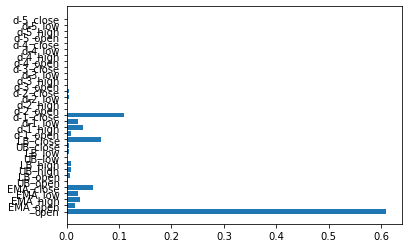

In [10]:
importance = rf.feature_importances_

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

importance

from matplotlib import pyplot as plt
plt.barh(x_train.columns, rf.feature_importances_)

In [11]:
def exp041(df, stock, inputColumns = []):
    #df = getPeriod(df, '2020.03.02','2021.04.30', True)
    #print(df)
    df_train = getPeriod(df, TRAIN_BEGIN, TRAIN_END)
    df_test = getPeriod(df, TEST_BEGIN, TEST_END)
    
    if(inputColumns == []):
        x_train = df_train.drop(['date', 'high', 'low', 'close'], axis=1)
        y_train = df_train[['high','low']]

        x_test = df_test.drop(['date', 'high', 'low', 'close'], axis=1)
        y_test = df_test[['high','low']]
    else:
        x_train = df_train[inputColumns]
        y_train = df_train[['high','low']]

        x_test = df_test[inputColumns]
        y_test = df_test[['high','low']]

    for i in range(1, 5):    
        rf = RandomForestRegressor(n_estimators = 1)
        rf.fit(x_train, y_train);
        y_pred = rf.predict(x_test)
        
        print(i)
        errorMax = mape(y_test['high'],y_pred[:,0])
        errorMin = mape(y_test['low'],y_pred[:,1])
        printResult(errorMax, 'High')
        printResult(errorMin, 'Low')
    
    importance = rf.feature_importances_
    
    featureImp = []
    for feat, importance in zip(x_train.columns, rf.feature_importances_):  
        temp = [feat, importance*100]
        featureImp.append(temp)

    fT_df = pd.DataFrame(featureImp, columns = ['Feature', 'Importance'])
    print (fT_df.sort_values('Importance', ascending = False))
    
    #print (mape(y_test['high'],y_pred[:,0]))
    #print (mape(y_test['low'],y_pred[:,1]))
    #print (mae(y_test['high'],y_pred[:,0]))
    #print (mae(y_test['low'],y_pred[:,1]))
    
    return errorMax, errorMin, y_pred, y_test

a,b,c,d = exp041(initialDf, STOCK)

1
High: 2.43 +- 1.75 %
Low: 1.98 +- 1.22 %
2
High: 2.44 +- 1.8 %
Low: 2.94 +- 1.77 %
3
High: 1.62 +- 1.37 %
Low: 1.95 +- 1.09 %
4
High: 1.39 +- 1.38 %
Low: 1.57 +- 0.63 %
      Feature  Importance
0        open   77.114106
11   UB_close   17.414499
16  d-1_close    2.363482
14   d-1_high    2.252397
1    EMA_open    0.362592
4   EMA_close    0.087088
32  d-5_close    0.065623
28  d-4_close    0.036138
21   d-3_open    0.035035
15    d-1_low    0.027519
12   LB_close    0.024912
13   d-1_open    0.023603
17   d-2_open    0.018435
27    d-4_low    0.018007
8     LB_high    0.016861
7     UB_high    0.016700
9      UB_low    0.015306
3     EMA_low    0.014581
6     LB_open    0.013244
5     UB_open    0.012257
10     LB_low    0.011186
18   d-2_high    0.010509
2    EMA_high    0.008757
31    d-5_low    0.007546
20  d-2_close    0.005445
19    d-2_low    0.004983
26   d-4_high    0.004197
25   d-4_open    0.003797
24  d-3_close    0.003404
30   d-5_high    0.003320
23    d-3_low    0.0028

In [12]:
printResult(a, 'High')
printResult(b, 'Low')

High: 1.39 +- 1.38 %
Low: 1.57 +- 0.63 %


In [13]:
#Prediction of VVAR3 from June, 28 to July, 08
d['high_pred'] = c[:,0].round(2)
d['low_pred'] = c[:,1]
d

,high,low,high_pred,low_pred
612,16.15,15.61,16.01,15.43
613,16.07,15.67,16.01,15.43
614,15.98,15.71,16.01,15.43
615,15.93,15.30,16.01,15.43
616,15.76,15.37,15.71,15.11
617,15.69,15.25,16.01,15.43
618,15.46,14.98,16.01,15.43
619,15.27,14.87,15.88,15.17
620,14.90,14.53,15.00,14.67
